In [1]:
import numpy as np
from distutils.version import LooseVersion
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shutil import copy2
from PIL import Image, ImageEnhance
import os
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rescale
from math import sqrt
from skimage import exposure
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.manifold import Isomap
from sklearn.feature_extraction import image
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import random
from glob import glob

C:\Users\PG_MG\Anaconda3\envs\XAIconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PG_MG\Anaconda3\envs\XAIconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\PG_MG\Anaconda3\envs\XAIconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
random.seed(2020)
# find all of the files in the directory
hlist=[]
ilist=[]

folders=["../data/skin_lesions/h-mal/", "../data/skin_lesions/org-mal/"]
lists=[hlist,ilist]
for folder, filelist in zip(folders, lists):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png"):
                filelist.append(os.path.join(root, file))
                
print('Found ', len(hlist),' heatmap files.')
print('Found ', len(ilist),' org files.')

N_CLUSTERS = 4
IM_FEATURES = 10
H_FEATURES = 20
N_NEIGHBORS = 8
# select clustering algorithm
# 1 - spectral clustering
# 0 - kmeans
clustering_algorithm = 1
mode = 'normal'

Found  884  heatmap files.
Found  884  org files.


In [5]:
heatmaps=[]
images=[]

# loading images
datasets = [heatmaps, images]
for files,dataset in zip(lists,datasets):
    for file in tqdm(files):
        if mode == 'enhanced':
            im = Image.open(file)
            enhancer = ImageEnhance.Contrast(im)
            enhanced_im = enhancer.enhance(1.2)
            enhanced_im=np.array(enhanced_im)
            wb_im = exposure.equalize_adapthist(enhanced_im, clip_limit=0.01)[:,:,0]
            rescaled_heatmap = rescale(wb_im, 0.2, mode="reflect")
            smoothened_heatmap = gaussian_filter(rescaled_heatmap, sigma=3.5)
            dataset.append(smoothened_heatmap.reshape(int(sqrt(smoothened_heatmap.size))*int(sqrt(smoothened_heatmap.size))))
        elif mode == 'normal':
            np_image=[]
            np_image = np.array(Image.open(file))
            rescaled_heatmap = rescale(np_image, 0.2, mode="reflect")
            rescaled_heatmap=rescaled_heatmap[:,:,0]
            dataset.append(rescaled_heatmap.reshape(rescaled_heatmap.shape[0]*rescaled_heatmap.shape[1]))


print('Loaded ', len(heatmaps),' heatmaps.')
print('Loaded ', len(images),' images.')    

100%|████████████████████████████████████████████████████████████████████████████████| 884/884 [00:10<00:00, 86.67it/s]

Loaded  884  heatmaps.
Loaded  884  images.


Visualize the resulting regions



In [6]:
# in this version of spray Isomap will be used also for dimensionalkity reduction
# hence n_components=20 
scaler = MinMaxScaler()
isomap = Isomap(n_neighbors=N_NEIGHBORS,n_components=H_FEATURES,eigen_solver='arpack',path_method='FW', neighbors_algorithm='brute')
h_isomap= isomap.fit_transform(heatmaps)
h_isomap = scaler.fit_transform(h_isomap)

isomap = Isomap(n_neighbors=N_NEIGHBORS,n_components=IM_FEATURES,eigen_solver='arpack',path_method='FW', neighbors_algorithm='brute')
im_isomap= isomap.fit_transform(images)
im_isomap = scaler.fit_transform(im_isomap)


In [7]:
def plot_results(N_CLUSTERS,h_isomap,im_isomap,labels):
    fig=plt.figure(figsize=(15, 8))
    ax = Axes3D(fig)
    for cluster in range(0,N_CLUSTERS):
        ax.scatter(h_isomap[labels==cluster,0],h_isomap[labels==cluster,1],h_isomap[labels==cluster,2])
    plt.show()

    fig=plt.figure(figsize=(15, 8))
    ax = Axes3D(fig)
    for cluster in range(0,N_CLUSTERS):
        ax.scatter(im_isomap[labels==cluster,0],im_isomap[labels==cluster,1],im_isomap[labels==cluster,2])
    plt.show()

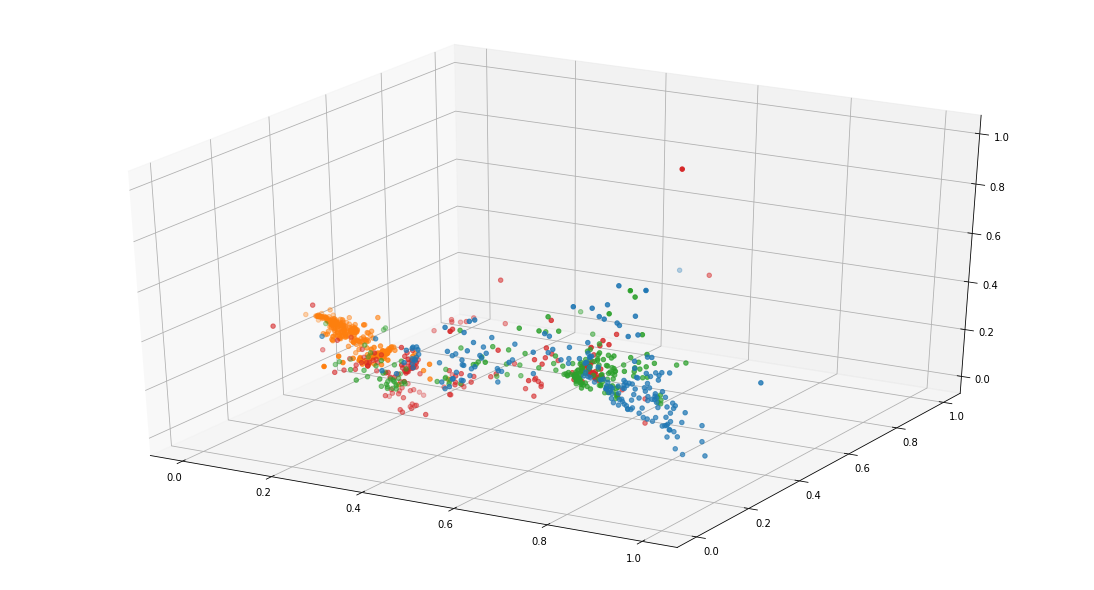

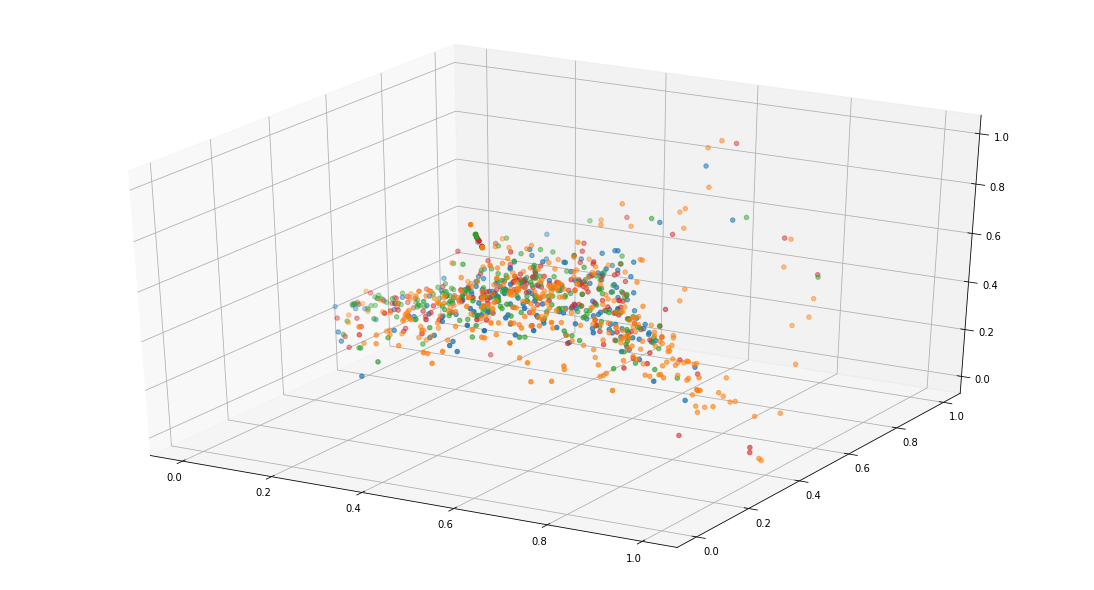

In [8]:
# cluster based on heatmaps
if clustering_algorithm == 0:
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(h_isomap)
    labels = kmeans.predict(h_isomap)
elif clustering_algorithm == 1:
    clustering = SpectralClustering(n_clusters=N_CLUSTERS,
                                    assign_labels="discretize",
                                    n_neighbors=N_NEIGHBORS,
                                    random_state=0).fit(h_isomap)
    labels = clustering.labels_

# plot results
plot_results(N_CLUSTERS,h_isomap,im_isomap,labels)

# copy results to experiments folder
for label, image in zip(labels, ilist):
    directory = "../experiments/gebi/heatmaps/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(image, directory)

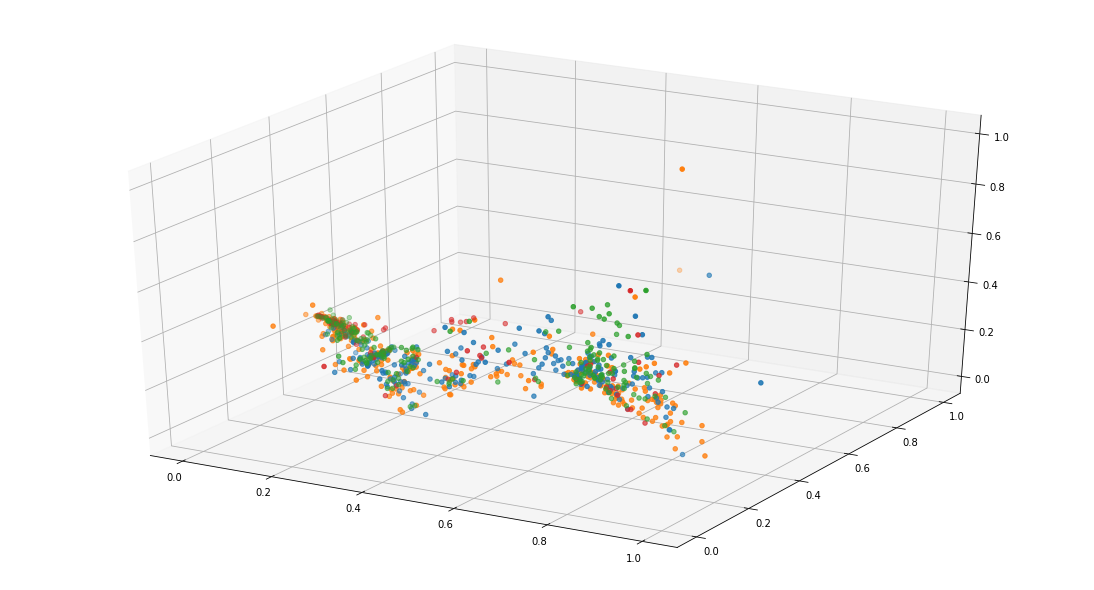

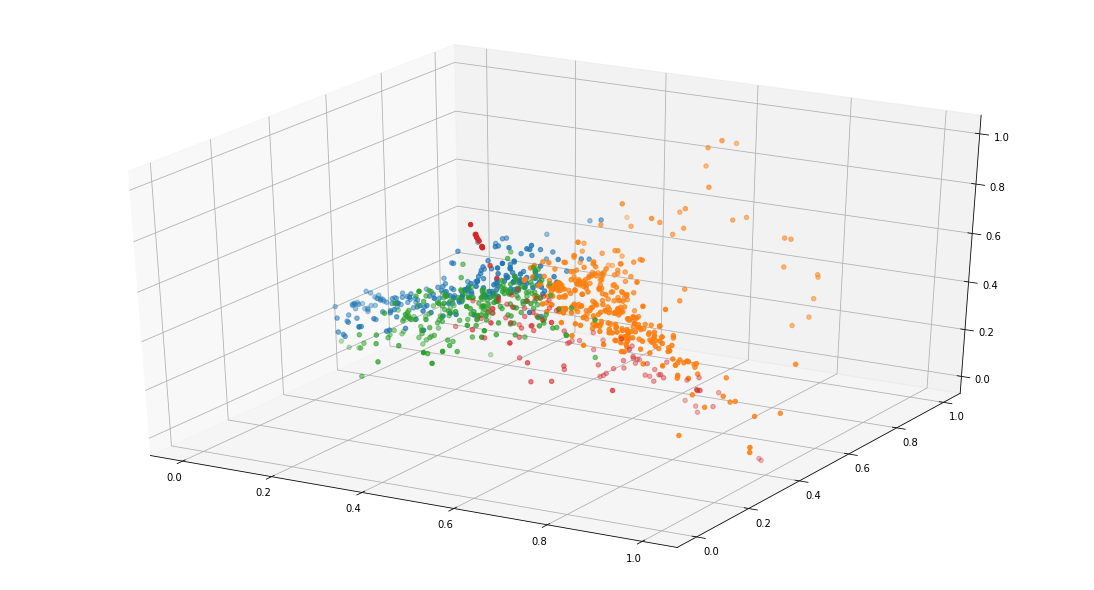

In [9]:
if clustering_algorithm == 0:
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(im_isomap)
    labels = kmeans.predict(im_isomap)
elif clustering_algorithm == 1:
    clustering = SpectralClustering(n_clusters=N_CLUSTERS,
                                    assign_labels="discretize",
                                    n_neighbors=N_NEIGHBORS,
                                    random_state=0).fit(im_isomap)
    labels = clustering.labels_

plot_results(N_CLUSTERS,h_isomap,im_isomap,labels)

# copy results to experiments folder
for label, image in zip(labels, ilist):
    directory = "../experiments/gebi/images/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(image, directory)

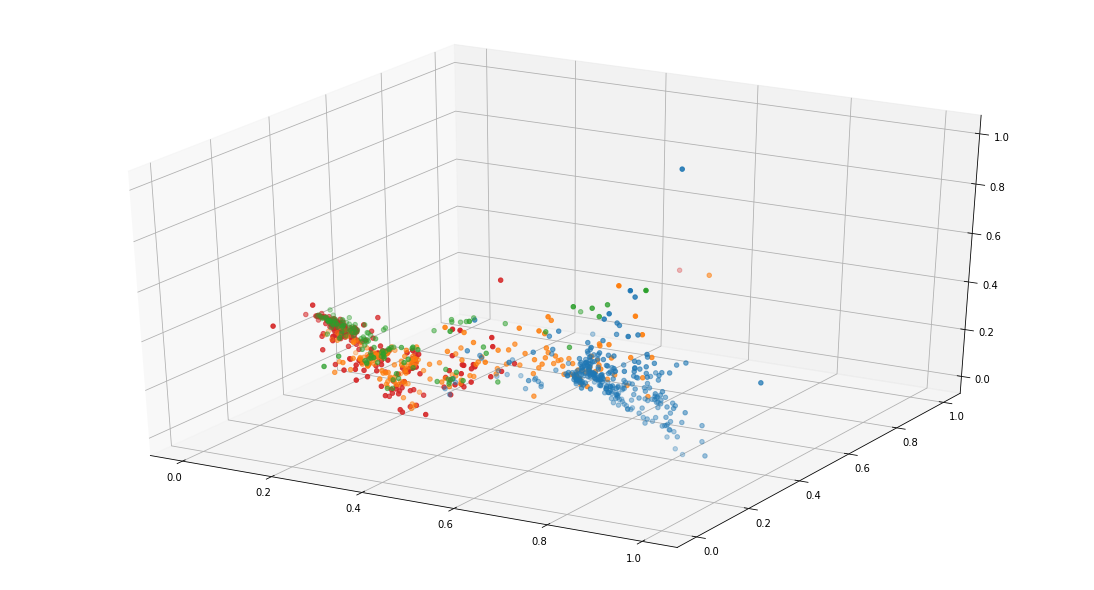

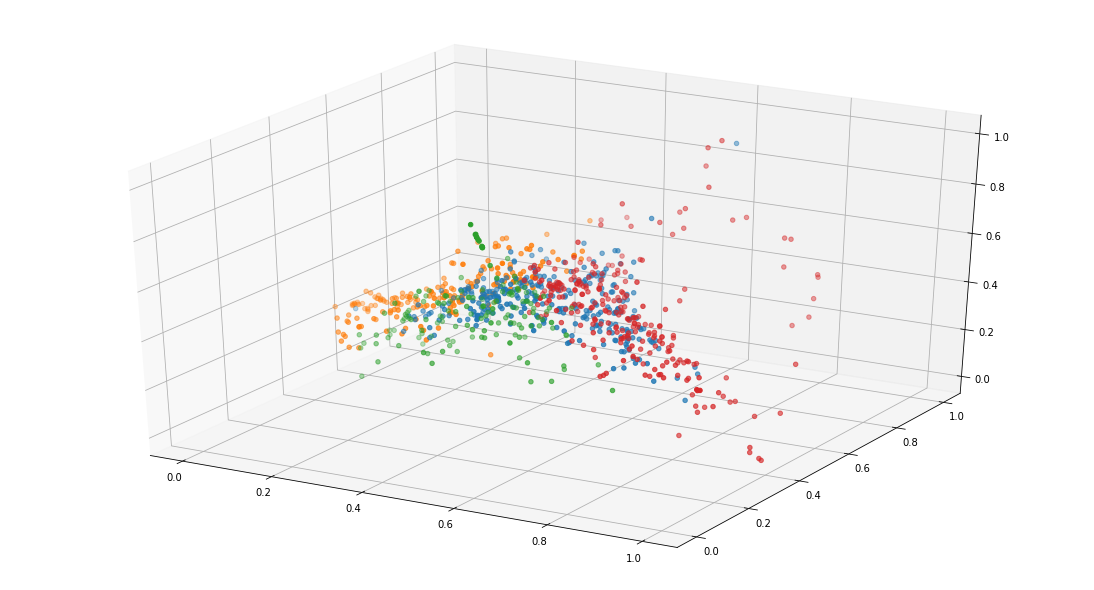

In [10]:
# cluster both heatmaps and images
concat = []
concat = np.concatenate((h_isomap,im_isomap), axis=1)
if clustering_algorithm == 0:
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(concat)
    labels = kmeans.predict(concat)
elif clustering_algorithm == 1:
    clustering = SpectralClustering(n_clusters=N_CLUSTERS,
                                    assign_labels="discretize",
                                    n_neighbors=N_NEIGHBORS,
                                    random_state=0).fit(concat)
    labels = clustering.labels_

plot_results(N_CLUSTERS,h_isomap,im_isomap,labels)

# copy results to experiments folder
for label, image in zip(labels, ilist):
    directory = "../experiments/gebi/heatmaps_images/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(image, directory)